# Fake Moon Injector

### Exomoon team 
#### June 2023

In [1]:
#!/usr/bin/python
# -*- coding: latin-1 -*-
import matplotlib.pyplot as plt
import vip_hci as vip
import pandas as pd
import numpy as np
import shutil
import os

from vip_hci.fm import *
from vip_hci.metrics import *
from vip_hci.preproc import *
from vip_hci.var import *
from vip_hci.psfsub import *

In [2]:
vip.__version__

'1.2.2'

### Loading real data (template)

In [3]:
root_folder = './data/real/dhtau/'

# cube
cube_in = os.path.join(root_folder, 'center_im.fits')     
cube1,hdr= vip.fits.open_fits(cube_in,header=True)
vip.fits.info_fits(cube_in) 

#rotation angles
rot = os.path.join(root_folder, 'rotnth.fits')     
rot1,hdr= vip.fits.open_fits(rot,header=True) 


#PSF of the star
psf=os.path.join(root_folder, 'median_unsat.fits')  
psf1,hdr= vip.fits.open_fits(psf,header=True) 

Fits HDU-0 data and header successfully loaded. Data shape: (2, 80, 1024, 1024)
Filename: ./data/real/dhtau/center_im.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     991   (1024, 1024, 80, 2)   float32   
Fits HDU-0 data and header successfully loaded. Data shape: (80,)
Fits HDU-0 data and header successfully loaded. Data shape: (2, 3, 64, 64)


Choose a wavelength (`lambda_filter`) (H2=0  H3=1 / K1=0  K2=1) and either the initial (0) or final (1) PSF (`psf_pos`)

In [4]:
lambda_filter = 0
psf_pos       = 0

In [5]:
cube=cube1[lambda_filter,:,:,:] # select cube on the chosen lambda wavelength
cube.shape

(80, 1024, 1024)

SPHERE frames are EVEN (1024x1024) but VIP needs ODD frames

In [6]:
%%time
n_frames, height, width = cube.shape

cube_shifted = np.zeros((n_frames, height, width))
for i in range (len(cube)):
       cube_shifted[i,:,:]=frame_shift(cube[i,:,:], -1, -1)  

ycube_center,xcube_center=frame_center(cube[0,:,:])
if len(cube[1,:,1])%2==0:
    ycen=ycube_center-0.5
    xcen=xcube_center-0.5
    newdim = height-1 # we assume and square matrix
    cube_crop=cube_crop_frames(cube_shifted,newdim,xy=[int(ycen),int(xcen)], force=True)    #tagliamo l'immagine'''
else :
    cube_crop=cube

New shape: (80, 1023, 1023)
CPU times: user 7.04 s, sys: 1.32 s, total: 8.36 s
Wall time: 8.38 s


we set up important variables that we are going to use

In [7]:
dim1, dim2, dim3 = cube_crop.shape
pixel = 0.01225   #pixel scale arcsec/pixel for IRDIS/SPHERE
rot   = -rot1  

VIP wants an ODD frame once again. This time, we do not center it manually, as we will fit a 2-dimensional Gaussian that will automatically learn the center of the Point Spread Function (PSF).

Afterward, we will utilize the learned center to recenter the entire cube of PSFs.

`Size` is even (while input frame size is odd). Setting `size` to 31 pixels


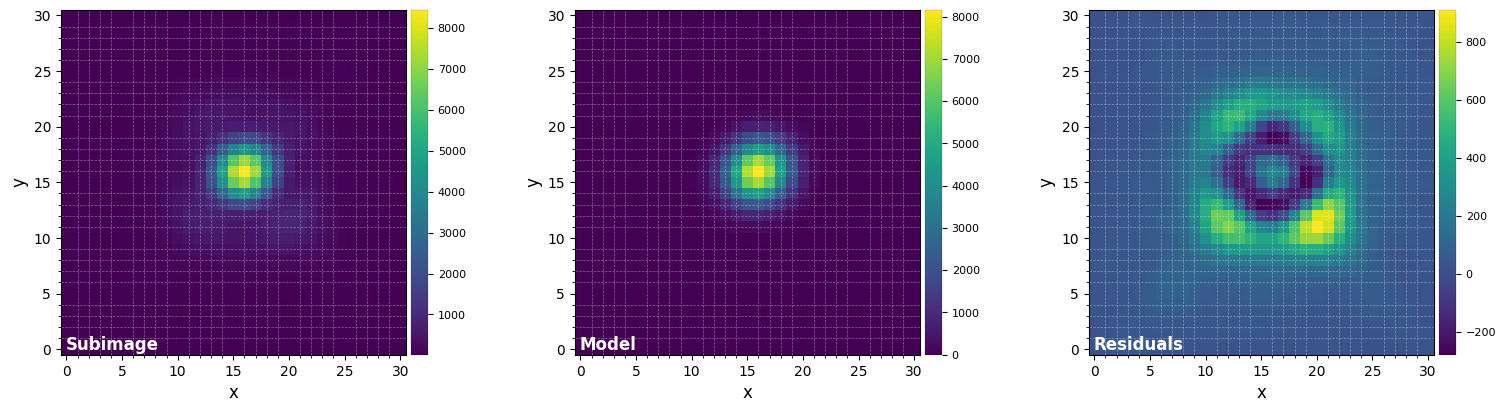

FWHM_y = 4.317577990198009
FWHM_x = 4.632907037350777 

centroid y = 31.984132133226225
centroid x = 31.951609924544403
centroid y subim = 15.984132133226227
centroid x subim = 15.951609924544403 

amplitude = 8162.747113087424
theta = -685.2603953682157
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-06-26 14:47:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.149574
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


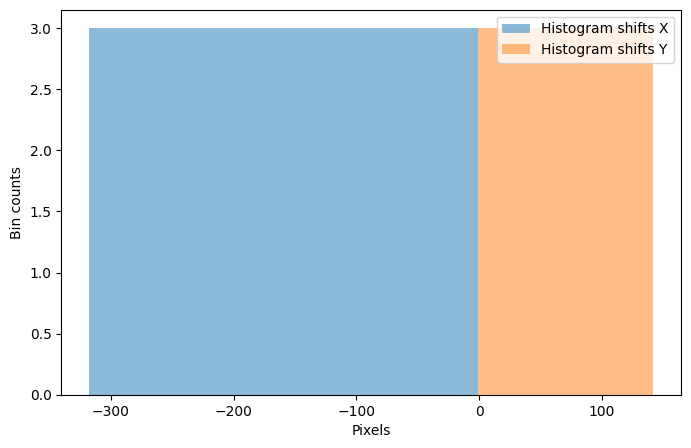

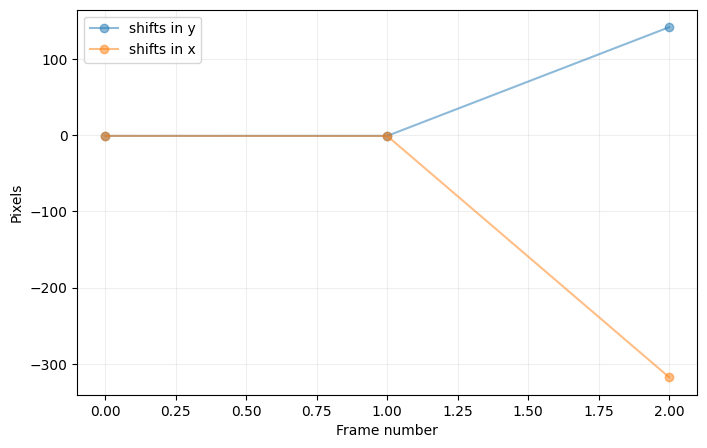

In [8]:
psf2  = psf1[int(lambda_filter), :, :-1, :-1] 

#output: fwhm of this PSF in the wavelength chosen 
fit = vip.var.fit_2dgaussian(psf2[psf_pos,:,:], crop=True, cropsize=30, debug=True, full_output=True) 
fwhm_sphere = np.mean([fit.fwhm_y,fit.fwhm_x]) 

y_cent, x_cent = frame_center(psf2[int(psf_pos)]) 
y_c=int(y_cent)
x_c=int(x_cent)
psf_center, y0_sh, x0_sh = cube_recenter_2dfit(psf2, 
                                               (y_c, x_c), 
                                               fwhm_sphere,model='gauss',
                                               nproc=1, 
                                               subi_size=7, negative=False,
                                               full_output=True, debug=False) 

Now we take one PSF and normalize it within one full width. 

In [9]:
psf_center1=psf_center[psf_pos,:,:]


#IMPORTANT: fwhm_flux is the flux of the star in one full width 
psf_norm, fwhm_flux,fwhm=normalize_psf(psf_center1, fwhm=fwhm_sphere, size=None, threshold=None, mask_core=None,
             full_output=True, verbose=True)  #psf normalizzata ad 1

Flux in 1xFWHM aperture: 91267.747


### Fake Moon Injection 

In [10]:
rad_theta = [(250, 120), (100, 250), (150, 50), (300, 270), (400, 570), (280, 670)]
fluxes = [150, 200, 250, 100, 300, 180]

In [11]:
reduced_injection = cube_crop.copy()

for (radius, theta), f in zip(rad_theta, fluxes):
    zero_template = np.zeros_like(cube_crop)
    cube_fk = cube_inject_companions(zero_template, 
                                     psf_norm, 
                                     rot, 
                                     flevel=f, 
                                     rad_dists=radius, 
                                     theta=theta, 
                                     plsc=pixel)
    
    reduced_injection+=cube_fk

Branch 1:
	(X,Y)=(386.00, 727.51) at 3.06 arcsec (250.00 pxs from center)
Branch 1:
	(X,Y)=(476.80, 417.03) at 1.23 arcsec (100.00 pxs from center)
Branch 1:
	(X,Y)=(607.42, 625.91) at 1.84 arcsec (150.00 pxs from center)
Branch 1:
	(X,Y)=(511.00, 211.00) at 3.68 arcsec (300.00 pxs from center)
Branch 1:
	(X,Y)=(164.59, 311.00) at 4.90 arcsec (400.00 pxs from center)
Branch 1:
	(X,Y)=(690.98, 296.51) at 3.43 arcsec (280.00 pxs from center)


Text(0.5, 1.0, 'Fake')

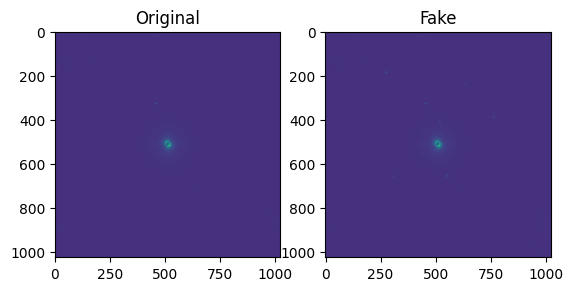

In [12]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cube_crop[0])
axes[0].set_title('Original')

axes[1].imshow(reduced_injection[0])
axes[1].set_title('Fake')

## Saving fake dataset

In [13]:
target_folder = './data/fake/f_dhtau'

os.makedirs(target_folder, exist_ok=True)

In [14]:
vip.fits.write_fits(os.path.join(target_folder, 'center_im.fits'), reduced_injection)

Fits file successfully saved


We also have to copy and paste rotational angles and PSFs from the real dataset

In [15]:
for file in ['rotnth.fits', 'median_unsat.fits']:
    origin = os.path.join(root_folder, file) 
    target = os.path.join(target_folder, file)
    shutil.copyfile(origin, target)  

In [16]:
ls './data/fake/f_dhtau'

center_im.fits  median_unsat.fits  rotnth.fits


## Optional [time expensive!!!]

In [ ]:
%%time
fr_pca=pca(reduced_injection, rot)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-06-26 14:48:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 16.721 GB
System available memory = 8.594 GB
Done vectorizing the frames. Matrix shape: (80, 1046529)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:09.032652
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [ ]:
vip.fits.write_fits(os.path.join(target_folder, 'fr_pca.fits'), fr_pca)